In [1]:
using FermiCG
using PyCall
using Plots
using LinearAlgebra
using Printf

┌ Info: Precompiling FermiCG [855c3b3a-d9bb-4919-8b00-0b3cfbdffb6f]
└ @ Base loading.jl:1278


Define molecule and run HF

In [2]:
molecule = "
 C     4.93354    -2.84833     0.00000
 C     4.93321    -1.45861     0.00000
 C     3.73075    -0.73168     0.00000
 C     2.49032    -1.43783     0.00000
 C     1.23513    -0.71311     0.00000
 C     1.23513     0.71311     0.00000
 C     2.49032     1.43783     0.00000
 C     3.73075     0.73168     0.00000
 C     4.93321     1.45861     0.00000
 C     4.93354     2.84833     0.00000
 C     3.72991     3.54302     0.00000
 C     2.49908     2.86514     0.00000
 C     1.23174     3.59686    -0.00000
 C     1.20340     5.00170    -0.00000
 C     0.00000     5.69682    -0.00000
 C    -1.20340     5.00170    -0.00000
 C    -1.23174     3.59686    -0.00000
 C     0.00000     2.87564    -0.00000
 C     0.00000     1.42626    -0.00000
 C    -1.23513     0.71311    -0.00000
 C    -2.49032     1.43783     0.00000
 C    -2.49908     2.86514    -0.00000
 C    -3.72991     3.54302    -0.00000
 C    -4.93354     2.84833     0.00000
 C    -4.93321     1.45861     0.00000
 C    -3.73075     0.73168     0.00000
 C    -3.73075    -0.73168     0.00000
 C    -4.93321    -1.45861     0.00000
 C    -4.93354    -2.84833     0.00000
 C    -3.72991    -3.54302     0.00000
 C    -2.49908    -2.86514    -0.00000
 C    -2.49032    -1.43783    -0.00000
 C    -1.23513    -0.71311    -0.00000
 C    -0.00000    -1.42626    -0.00000
 C    -0.00000    -2.87564    -0.00000
 C    -1.23174    -3.59686    -0.00000
 C    -1.20340    -5.00170    -0.00000
 C     0.00000    -5.69682    -0.00000
 C     1.20340    -5.00170    -0.00000
 C     1.23174    -3.59686    -0.00000
 C     2.49908    -2.86514    -0.00000
 C     3.72991    -3.54302     0.00000
 H     5.87949    -3.39439     0.00000
 H     5.89025    -0.93984     0.00000
 H     5.89025     0.93984     0.00000
 H     5.87949     3.39439     0.00000
 H     3.75925     4.63123     0.00000
 H     2.13117     5.57119    -0.00000
 H     0.00000     6.78906    -0.00000
 H    -2.13117     5.57119    -0.00000
 H    -3.75925     4.63123    -0.00000
 H    -5.87949     3.39439     0.00000
 H    -5.89025     0.93984     0.00000
 H    -5.89025    -0.93984     0.00000
 H    -5.87949    -3.39439     0.00000
 H    -3.75925    -4.63123     0.00000
 H    -2.13117    -5.57119    -0.00000
 H     0.00000    -6.78906    -0.00000
 H     2.13117    -5.57119    -0.00000
 H     3.75925    -4.63123    -0.00000
"

atoms = []
for (li,line) in enumerate(split(rstrip(lstrip(molecule)), "\n"))
    l = split(line)
    push!(atoms, Atom(li, l[1], parse.(Float64,l[2:4])))
end

cas_nel = 42
cas_norb = 42

basis = "sto-3g"

# 
# Create FermiCG.Molecule type
mol     = Molecule(0,1,atoms,basis)

mf = FermiCG.pyscf_do_scf(mol, verbose=2)
C = mf.mo_coeff
nbas = size(C)[1]
FermiCG.pyscf_write_molden(mol, C, filename="hf_canonical.molden")

# 
# Number of electrons
tot_na = (42*6 + 18) ÷ 2
tot_nb = (42*6 + 18) ÷ 2
tot_n_elec = tot_na + tot_nb
@printf(" Hartree-Fock Energy: %12.8f", mf.e_tot)

sto-3g


228-element Array{Float64,1}:
 -11.042357421504128
 -11.042357255300121
 -11.04228533183649
 -11.042189691807117
 -11.04218953927737
 -11.042134721717792
 -11.041971110189843
 -11.041968836523818
 -11.041966810296637
 -11.041960210805158
 -11.04195769865807
 -11.041952761260413
 -11.041858871489124
   ⋮
   1.0761722519180827
   1.0868374198474866
   1.0868488754945889
   1.0902638866764582
   1.1137214274980756
   1.1137234087114654
   1.1599132403850658
   1.159935550002324
   1.1734627835171458
   1.1734848500444564
   1.2138573595041848
   1.21918996571063

MO Energies
 Hartree-Fock Energy: -1581.72678760

Now separate π and σ spaces. For now, I've manually inspected the orbitals to separate out the π space. However, we eventually will want automated ways to do this.

In [3]:
#
# Get active space
act_space = [93,
    101, 102,
    109, 110,
    113,
    116,
    collect(122:153)..., 
    157, 158,
    167]
n_frozen = tot_na - 21
#n_frozen = 4*18 + 12
inactive_space = setdiff(1:nbas,act_space)


occ_space = inactive_space[1:n_frozen]
vir_space = inactive_space[n_frozen+1:end]
Cact = C[:,act_space]
Cocc = C[:,occ_space]
Cvir = C[:,vir_space]

n_core = 42
core_space = inactive_space[1:n_core]
sig_space = inactive_space[n_core+1:end]
Csig = C[:,sig_space]

# Number of active electrons 
ne = 42
na = 21
nb = 21
#
# Localize Orbitals (split localize active)
split_loc = false
if split_loc
    Cact[:,1:na] = FermiCG.localize(Cact[:,1:na], "boys", mf)
    Cact[:,na+1:end] = FermiCG.localize(Cact[:,na+1:end], "boys", mf)
else
    Cact = FermiCG.localize(Cact, "boys", mf)
end
Csig = FermiCG.localize(Csig, "boys", mf)
FermiCG.pyscf_write_molden(mol, Cact, filename="act.molden")
FermiCG.pyscf_write_molden(mol, Csig, filename="sig.molden")



Set conv_tol_grad to 0.000316228
macro= 1  f(x)= -2577.5533544161  delta_f= -2577.55  |g|= 0.092425  1 KF 3 Hx
macro= 2  f(x)= -2577.5533544161  delta_f= 1.81899e-12  |g|= 1.179e-06  1 KF 1 Hx
macro X = 2  f(x)= -2577.5533544161  |g|= 1.179e-06  4 intor 2 KF 4 Hx
Set conv_tol_grad to 0.000316228
macro= 1  f(x)= -10465.959934493  delta_f= -10466  |g|= 5.00568  4 KF 20 Hx
macro= 2  f(x)= -10488.985796888  delta_f= -23.0259  |g|= 1.83463  4 KF 20 Hx
macro= 3  f(x)= -10497.615527118  delta_f= -8.62973  |g|= 1.86278  4 KF 20 Hx
macro= 4  f(x)= -10499.317221729  delta_f= -1.70169  |g|= 0.227154  3 KF 6 Hx
macro= 5  f(x)= -10499.317996968  delta_f= -0.000775239  |g|= 0.00216976  2 KF 5 Hx
macro= 6  f(x)= -10499.317996968  delta_f= 1.81899e-12  |g|= 5.06425e-05  1 KF 1 Hx
macro X = 6  f(x)= -10499.317996968  |g|= 5.06425e-05  12 intor 18 KF 72 Hx


1

Using these orbitals, let's semi-algorithmically cluster the system. We'll start by separately looking at the π and σ spaces. Using these orbital orderings, we can inspect to see how local the exchange matrix is.


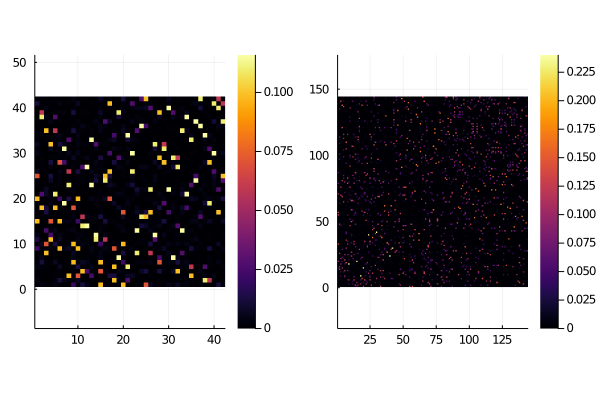

In [4]:
#
# Using these orbitals, let's semi-algorithmically cluster the system. 
# We'll start by separately looking at the π and σ spaces
# Using these orbital orderings, we can inspect to see how local the exchange matrix is
h,j,k = FermiCG.pyscf_get_jk(mol, C[:,1:tot_na] * C[:,1:tot_na]');

k1 = Cact'*(k)*Cact
k2 = Csig'*(k)*Csig
k1 = k1 - Diagonal(diag(k1))
k2 = k2 - Diagonal(diag(k2))
p1 = heatmap(abs.(k1), aspect_ratio=:equal)
p2 = heatmap(abs.(k2), aspect_ratio=:equal)
plot(p1, p2, layout = @layout [a  b])

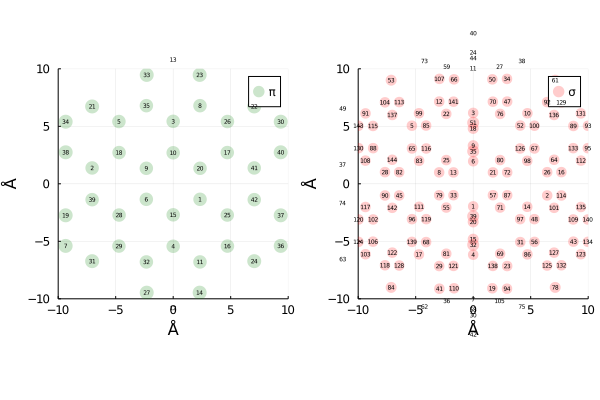

In [5]:
# 
# We can also inspect the orbital positions by looking at <r> and <r⋅r>
pymol = FermiCG.make_pyscf_mole(mol);
r1 = pymol.intor_symmetric("int1e_r");
r2 = pymol.intor_symmetric("int1e_r2");
rx_act = Cact'*r1[1,:,:]*Cact;
ry_act = Cact'*r1[2,:,:]*Cact;
rz_act = Cact'*r1[3,:,:]*Cact;
rx_sig = Csig'*r1[1,:,:]*Csig;
ry_sig = Csig'*r1[2,:,:]*Csig;
rz_sig = Csig'*r1[3,:,:]*Csig;
r2_act = Cact'*r2*Cact;
r2_sig = Csig'*r2*Csig;

var_act = diag(r2_act) - diag(rx_act).*diag(rx_act)- diag(ry_act).*diag(ry_act)- diag(rz_act).*diag(rz_act)
var_sig = diag(r2_sig) - diag(rx_sig).*diag(rx_sig)- diag(ry_sig).*diag(ry_sig)- diag(rz_sig).*diag(rz_sig)


p1 = scatter(diag(rx_act), diag(ry_act), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_act), 
    labels="π",xlims=(-10,10),ylims=(-10,10),  legendfont = font(8),    
    markeralpha = 0.2,
    markercolor = :green,
    markerstrokewidth = 0,
)

[annotate!(rx_act[i,i],ry_act[i,i],i, font(4)) for i in 1:size(rx_act,1)]

p2 = scatter(diag(rx_sig), diag(ry_sig), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_sig), 
    labels="σ",xlims=(-10,10),ylims=(-10,10),     
    markeralpha = 0.2,
    markercolor = :red,
    markerstrokewidth = 0,
)
[annotate!(rx_sig[i,i],ry_sig[i,i],i, font(4)) for i in 1:size(rx_sig,1)]

# p3 = scatter([diag(rx_act), diag(rx_sig)], [diag(ry_act), diag(ry_sig)], aspect_ratio=:equal, 
#     markersize=5*sqrt.([var_act..., var_sig...]), 
#     labels="σ",xlims=(-10,10),ylims=(-10,10),     
#     markeralpha = 0.2,
#     markercolor = :red,
#     markerstrokewidth = 0,
# )
# [annotate!(rx_sig[i,i],ry_sig[i,i],i, font(4)) for i in 1:size(rx_sig,1)]

plot(p1, p2, layout = @layout [a  b]
)
xlabel!("Å")
ylabel!("Å")

# 
# x and y axes are in units of Å. Each point corresponds to the mean position of the orbital, and the marker size 
# is 2*log(<r⋅r>). Thus, larger dots are more diffuse.

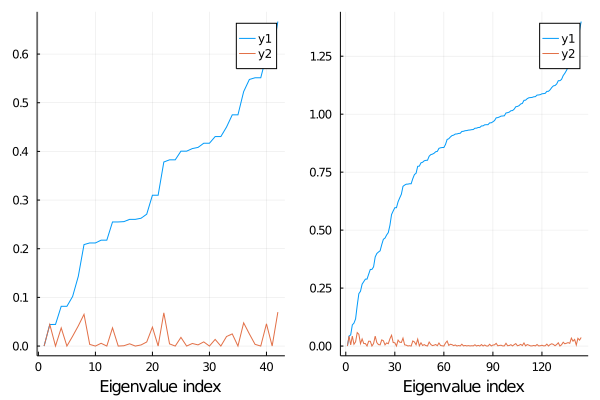

In [6]:
#
# From here, we could manually cluster. But we can instead try to use a k-means approach to spectral clustering. 
using Clustering
using SpectralClustering
# h,j,k = FermiCG.pyscf_get_jk(mol, C[:,1:tot_na] * C[:,1:tot_na]');


k1 = Cact'*(k)*Cact;
k2 = Csig'*(k)*Csig;

nvecs = 7
A = abs.(k1)
L = Diagonal([sum(A[i,:]) for i in 1:size(A,1)]) - A;
F = eigen(L);
p1 = plot(F.values, xlabel="Eigenvalue")
p1 = plot!( [0,[F.values[i+1]-F.values[i] for i in 1:length(F.values)-1]...], xlabel="Eigenvalue index")

A_act = F.vectors[:,1:nvecs]*F.vectors[:,1:nvecs]'
clustering_act = clusterize(KMeansClusterizer(nvecs), A_act).assignments;
perm_act = sortperm(clustering_act)
p2 = heatmap(A_act, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")
A_act = A_act[perm_act, perm_act]
p3 = heatmap(A_act, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")

Cact_sorted = Cact[:,perm_act]

nvecs = 7
A = abs.(k2)
L = Diagonal([sum(A[i,:]) for i in 1:size(A,1)]) - A;
F = eigen(L);
p4 = plot( F.values, xlabel="Eigenvalue index")
p4 = plot!( [0,[F.values[i+1]-F.values[i] for i in 1:length(F.values)-1]...], xlabel="Eigenvalue index")
A_sig = F.vectors[:,1:nvecs]*F.vectors[:,1:nvecs]'
p5 = heatmap(A_sig, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")

clustering_sig = clusterize(KMeansClusterizer(nvecs), A_sig).assignments;
perm_sig = sortperm(clustering_sig)
A_sig = A_sig[perm_sig, perm_sig]
p6 = heatmap(A_sig, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")

Csig_sorted = Csig[:,perm_sig]


FermiCG.pyscf_write_molden(mol, Cact_sorted, filename="act_sorted.molden");
FermiCG.pyscf_write_molden(mol, Csig_sorted, filename="sig_sorted.molden");
plot(p1, p4,  layout = @layout [a  b] )

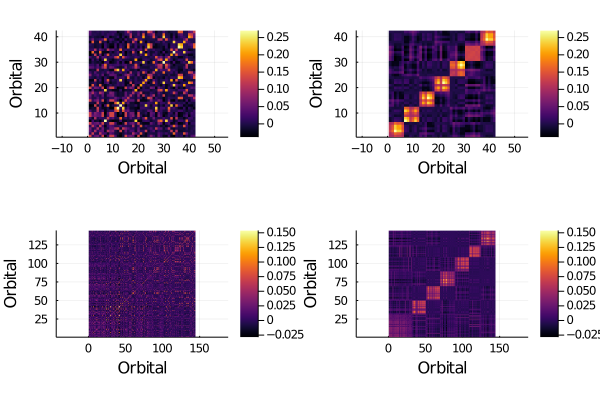

In [7]:
plot(p2, p3, p5, p6, layout = @layout [a  b ;c d])

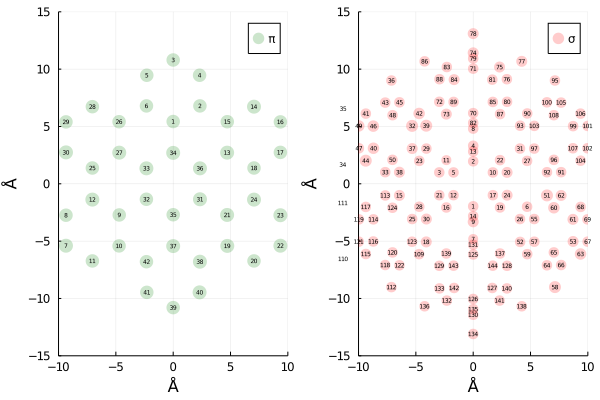

In [8]:
# 
# Now compare labelling
rx_act = Cact_sorted'*r1[1,:,:]*Cact_sorted;
ry_act = Cact_sorted'*r1[2,:,:]*Cact_sorted;
rx_sig = Csig_sorted'*r1[1,:,:]*Csig_sorted;
ry_sig = Csig_sorted'*r1[2,:,:]*Csig_sorted;
r2_act = Cact_sorted'*r2*Cact_sorted;
r2_sig = Csig_sorted'*r2*Csig_sorted;



p1 = scatter(diag(rx_act), diag(ry_act), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_act), 
    labels="π",xlims=(-10,10),ylims=(-15,15),  legendfont = font(8),    
    markeralpha = 0.2,
    markercolor = :green,
    markerstrokewidth = 0,
)



[annotate!(rx_act[i,i],ry_act[i,i],i, font(4)) for i in 1:size(rx_act,1)]

p2 = scatter(diag(rx_sig), diag(ry_sig), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_sig), 
    labels="σ",xlims=(-10,10),ylims=(-15,15),     
    markeralpha = 0.2,
    markercolor = :red,
    markerstrokewidth = 0,
    lw = 1
)

[annotate!(rx_sig[i,i],ry_sig[i,i],i, font(4)) for i in 1:size(rx_sig,1)]

plot(p1, p2, layout = @layout [a  b]
)
xlabel!("Å")
ylabel!("Å")

# 
# x and y axes are in units of Å. Each point corresponds to the mean position of the orbital, and the marker size 
# is 2*log(<r⋅r>). Thus, larger dots are more diffuse.

In [9]:
#
# Build Integrals
ints = FermiCG.pyscf_build_ints(mol, Cact_sorted, 2.0*Cocc*Cocc');
@printf(" Ecore: %12.8f", ints.h0)

 Ecore: -1459.77999732

In [10]:
#
# Define the clusters. These are tuples of orbital ranges.
clusters    = [(1:6), (7:12), (13:18), (19:24), (25:30), (31:36), (37:42)]

#
# Define the reference fock sectors. These are tuples of α, β electron counts.
# For the target clustering where we have 3 "benzene's", we'll have 6 electrons in each cluster.
init_fspace = [(3, 3),(3, 3),(3, 3),(3, 3),(3, 3),(3, 3),(3, 3)]

na = sum([i[1] for i in init_fspace]);
nb = sum([i[2] for i in init_fspace]);
ints.h0


-1459.7799973178599

In [11]:
# define clusters
clusters = [Cluster(i,collect(clusters[i])) for i = 1:length(clusters)]
display(clusters)

rdm1 = zeros(size(ints.h1))

e_cmf, U, Da, Db  = FermiCG.cmf_oo(ints, clusters, init_fspace, rdm1,
                                        max_iter_oo=40, verbose=0, gconv=1e-6, method="bfgs");


7-element Array{Cluster,1}:
 Cluster(1, [1, 2, 3, 4, 5, 6])
 Cluster(2, [7, 8, 9, 10, 11, 12])
 Cluster(3, [13, 14, 15, 16, 17, 18])
 Cluster(4, [19, 20, 21, 22, 23, 24])
 Cluster(5, [25, 26, 27, 28, 29, 30])
 Cluster(6, [31, 32, 33, 34, 35, 36])
 Cluster(7, [37, 38, 39, 40, 41, 42])

 ooCMF Iter:    1 Total= -1581.961100390318 Active= -122.181103072458 G=     1.09e+00
 ooCMF Iter:    2 Total= -1582.309967425823 Active= -122.529970107963 G=     3.38e-01
 ooCMF Iter:    3 Total= -1582.338283453763 Active= -122.558286135903 G=     9.52e-02
 ooCMF Iter:    4 Total= -1582.340435714541 Active= -122.560438396682 G=     3.48e-02
 ooCMF Iter:    5 Total= -1582.340855968208 Active= -122.560858650348 G=     2.80e-02
 ooCMF Iter:    6 Total= -1582.341239425973 Active= -122.561242108113 G=     2.71e-02
 ooCMF Iter:    7 Total= -1582.341453718147 Active= -122.561456400288 G=     1.01e-02
 ooCMF Iter:    8 Total= -1582.341475041778 Active= -122.561477723918 G=     3.49e-03
 ooCMF Iter:    9 Total= -1582.341477745248 Active= -122.561480427388 G=     1.98e-03
 ooCMF Iter:   10 Total= -1582.341479398917 Active= -122.561482081057 G=     1.66e-03
 ooCMF Iter:   11 Total= -1582.341480340472 Active= -122.561483022612 G=     1.33e-03
 ooCMF Iter:   12 Total= -1582.341480901026 Active= -1

 * Status: success

 * Candidate solution
    Final objective value:     -1.582341e+03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.36e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.25e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.12e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.60e-14 ≰ 0.0e+00
    |g(x)|                 = 6.18e-07 ≤ 1.0e-06

 * Work counters
    Seconds run:   267  (vs limit Inf)
    Iterations:    21
    f(x) calls:    43
    ∇f(x) calls:   43


 ooCMF Iter:   22 Total= -1582.341481191164 Active= -122.561483873304 G=     5.25e-06
*ooCMF -1582.34148119 


In [24]:
# Save molden file and rotate integrals
FermiCG.pyscf_write_molden(mol,Cact_sorted*U,filename="cmf.molden");
ints = FermiCG.orbital_rotation(ints,U);

In [ ]:
# Save molden file and rotate integrals
FermiCG.pyscf_write_molden(mol,Cact_sorted*U,filename="cmf.molden");
ints = FermiCG.orbital_rotation(ints,U);

In [13]:

max_roots = 100

#
# Build Cluster basis
cluster_bases = FermiCG.compute_cluster_eigenbasis(ints, clusters, verbose=0, max_roots=max_roots,
        init_fspace=init_fspace, rdm1a=Da, rdm1b=Db);

In [14]:
#
# Build ClusteredOperator
clustered_ham = FermiCG.extract_ClusteredTerms(ints, clusters);


 Remove duplicates
 Number of terms reduced from  9667 to  4039


In [15]:
# Build Cluster Operators
cluster_ops = FermiCG.compute_cluster_ops(cluster_bases, ints);

In [16]:
p_spaces = Vector{FermiCG.ClusterSubspace}()
q_spaces = Vector{FermiCG.ClusterSubspace}()

# define p spaces
for ci in clusters
    tss = FermiCG.ClusterSubspace(ci)
    tss[init_fspace[ci.idx]] = 1:1
    push!(p_spaces, tss)
end

# define q spaces
for tssp in p_spaces
    tss = FermiCG.get_ortho_compliment(tssp, cluster_bases[tssp.cluster.idx])
    push!(q_spaces, tss)
end

println(" ================= Cluster P Spaces ===================")
display.(p_spaces);
println(" ================= Cluster Q Spaces ===================")
display.(q_spaces);

 ================= Cluster P Spaces ===================
 Subspace for Cluster:    1 : IDX001:DIM4096:001|002|003|004|005|006|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    2 : IDX002:DIM4096:007|008|009|010|011|012|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    3 : IDX003:DIM4096:013|014|015|016|017|018|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    4 : IDX004:DIM4096:019|020|021|022|023|024|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    5 : IDX005:DIM4096:025|026|027|028|029|030|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    6 : IDX006:DIM4096:031|032|033|034|035|036|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    7 : IDX007:DIM4096:037|038|039|040|041|042|
      (3, 3)   Range:    1 → 1    Dim    1
 ================= Cluster Q Spaces ===================
 Subspace for Cluster:    1 : IDX001:DIM4096:001|002|003|004|005|006|
      (0, 0)   Range:    1 

      (0, 0)   Range:    1 → 1    Dim    1
      (3, 6)   Range:    1 → 20   Dim   20
      (4, 4)   Range:    1 → 100  Dim  100
      (1, 0)   Range:    1 → 6    Dim    6
      (3, 1)   Range:    1 → 100  Dim  100
      (4, 5)   Range:    1 → 90   Dim   90
      (4, 0)   Range:    1 → 15   Dim   15
      (2, 4)   Range:    1 → 100  Dim  100
      (6, 5)   Range:    1 → 6    Dim    6
      (1, 2)   Range:    1 → 90   Dim   90
      (5, 1)   Range:    1 → 36   Dim   36
      (3, 4)   Range:    1 → 100  Dim  100
      (2, 3)   Range:    1 → 100  Dim  100
      (2, 6)   Range:    1 → 15   Dim   15
      (0, 5)   Range:    1 → 6    Dim    6
      (5, 4)   Range:    1 → 90   Dim   90
      (2, 1)   Range:    1 → 90   Dim   90
      (2, 5)   Range:    1 → 90   Dim   90
      (1, 4)   Range:    1 → 90   Dim   90
      (0, 1)   Range:    1 → 6    Dim    6
      (0, 6)   Range:    1 → 1    Dim    1
      (1, 1)   Range:    1 → 36   Dim   36
      (2, 2)   Range:    1 → 100  Dim  100
      (5, 0

In [17]:
nroots = 1
ref_vector = FermiCG.TuckerState(clusters, p_spaces, q_spaces, 21, 21)
#
# initialize with eye
FermiCG.set_vector!(ref_vector, Matrix(1.0I, length(ref_vector),nroots))

ref  = FermiCG.CompressedTuckerState(ref_vector, thresh=-1);


In [18]:
# Solve for reference state (should be CMF energy)
@time e_ref, ref = FermiCG.tucker_ci_solve(ref, cluster_ops, clustered_ham, tol=1e-5);
display(ref)

 Solve CI with # variables = 1
 Iter:   1 SS: 1    E: -122.56148387*  R: 0.0e+00* 
 Memory used by cache: 258496.0
 17.569704 seconds (40.78 M allocations: 1.955 GiB, 9.73% gc time)

 --------------------------------------------------
 ---------- # Fockspaces -------------------:     1  
 ---------- # Configs    -------------------:     1  
 --------------------------------------------------
 Printing contributions greater than: 0.001000
 Weight              # configs (full)    (α,β)...            
 -------             --------- --------- ----------          
 1.000                                   ( 3,3 )( 3,3 )( 3,3 )( 3,3 )( 3,3 )( 3,3 )( 3,3 )
     1.000           1         1             1:1    1:1    1:1    1:1    1:1    1:1    1:1
 ---------                               ----------          
 --------------------------------------------------



In [19]:
# 
# Compute CMF Mean-field Zeroth-Order Hamiltonian
# display(typeof(cluster_ops))
FermiCG.add_cmf_operators!(cluster_ops, cluster_bases, ints, Da, Db);

In [20]:
# Solve for target
using StatProfilerHTML
@profilehtml e_var, v_var = FermiCG.solve_for_compressed_space(ref, cluster_ops, clustered_ham, 
    nbody=2, 
    H0="Hcmf",
    thresh_var=1e-3, 
    thresh_foi=1e-7, 
    thresh_pt =1e-6, 
    do_pt = false,
    tol_ci=1e-5, 
    tol_tucker=1e-5);

 --------------------------------------------------------------------
 Iterate PT-Var:       Iteration #: 1
 --------------------------------------------------------------------
 Compressed Ref state from:        1 →        1 (thresh =  1.0e-03)
 Norm of compressed state:   1.00000000 

 Solve zeroth-order problem. Dimension =          1
 Solve CI with # variables = 1
 Iter:   1 SS: 1    E: -122.56148387*  R: 0.0e+00* 
 Memory used by cache: 258496.0
  0.057692 seconds (21.34 k allocations: 1.158 MiB)

 Compute first order wavefunction. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 2
 17.458798 seconds (29.53 M allocations: 2.567 GiB, 9.33% gc time)
 FOIS Compressed from:        18541 →     5209 (thresh =  1.0e-07)
 Norm of |1>:              15021.64085306 
 Overlap between <1|0>:    -1.2e+02

 Solve in compressed FOIS. Dimension =         5209
 Solve CI with # variables = 5209
 Iter:   1 SS: 1    E: -122.56148387   R: 2.5e-01  
 Iter:  

 Iter:   3 SS: 3    E: -122.59962444*  R: 1.3e-06* 
 Memory used by cache: 258496.0
  4.117814 seconds (8.40 M allocations: 1.356 GiB, 30.05% gc time)

 Compute first order wavefunction. Reference space dim = 49
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 2
132.825098 seconds (84.50 M allocations: 62.082 GiB, 8.40% gc time)
 FOIS Compressed from:      4245644 →    97706 (thresh =  1.0e-07)
 Norm of |1>:              15031.68362733 
 Overlap between <1|0>:    -1.2e+02

 Solve in compressed FOIS. Dimension =        98354
 Solve CI with # variables = 98354
 Iter:   1 SS: 1    E: -122.59962444   R: 2.1e-01  
 Iter:   2 SS: 2    E: -122.64236647   R: 7.2e-02  
 Iter:   3 SS: 3    E: -122.64725274   R: 3.5e-02  
 Iter:   4 SS: 4    E: -122.64864406   R: 2.1e-02  
 Iter:   5 SS: 5    E: -122.64900924   R: 9.2e-03  
 Iter:   6 SS: 6    E: -122.64907842   R: 4.6e-03  
 Iter:   7 SS: 7    E: -122.64909679   R: 2.6e-03  
 Iter:   8 SS: 8    E: -122.64910218   R: 1.2e-03

┌ Info: Wrote profiling output to file:///Users/nmayhall/code/FermiCG/statprof/index.html .
└ @ StatProfilerHTML /Users/nmayhall/.julia/packages/StatProfilerHTML/yoDm8/src/StatProfilerHTML.jl:25


In [21]:
e_var, v_var = FermiCG.solve_for_compressed_space(ref, cluster_ops, clustered_ham, 
    nbody=2, 
    H0="Hcmf",
    thresh_var=1e-3, 
    thresh_foi=1e-7, 
    thresh_pt =1e-6, 
    do_pt = true,
    tol_ci=1e-5, 
    tol_tucker=1e-5);

 --------------------------------------------------------------------
 Iterate PT-Var:       Iteration #: 1
 --------------------------------------------------------------------
 Compressed Ref state from:        1 →        1 (thresh =  1.0e-03)
 Norm of compressed state:   1.00000000 

 Solve zeroth-order problem. Dimension =          1
 Solve CI with # variables = 1
 Iter:   1 SS: 1    E: -122.56148387*  R: 0.0e+00* 
 Memory used by cache: 258496.0
  1.752065 seconds (4.79 M allocations: 840.989 MiB, 18.35% gc time)

 Compute first order wavefunction. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 2
  3.086549 seconds (1.81 M allocations: 1.287 GiB, 11.69% gc time)
 FOIS Compressed from:        18541 →     5209 (thresh =  1.0e-07)
 Norm of |1>:              15021.64085306 
 Overlap between <1|0>:    -1.2e+02

 Compute PT vector. Reference space dim = 1
 Length of input      FOIS: 5209
 Length of compressed FOIS: 5209
 Build exact <X|V|0

 Compressed Ref state from:     3566 →       49 (thresh =  1.0e-03)
 Norm of compressed state:   1.00000000 

 Solve zeroth-order problem. Dimension =         49
 Solve CI with # variables = 49
 Iter:   1 SS: 1    E: -122.59881056   R: 2.0e-02  
 Iter:   2 SS: 2    E: -122.59935338   R: 3.2e-04  
 Iter:   3 SS: 3    E: -122.59935353*  R: 9.1e-07* 
 Memory used by cache: 258496.0
  3.104379 seconds (4.84 M allocations: 769.485 MiB, 9.03% gc time)

 Compute first order wavefunction. Reference space dim = 49
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 2
166.126593 seconds (84.45 M allocations: 61.900 GiB, 7.68% gc time)
 FOIS Compressed from:      3833942 →    94982 (thresh =  1.0e-07)
 Norm of |1>:              15031.49879802 
 Overlap between <1|0>:    -1.2e+02

 Compute PT vector. Reference space dim = 49
 Length of input      FOIS: 94982
 Length of compressed FOIS: 94874
 Build exact <X|V|0>
 46.960122 seconds (26.74 M allocations: 7.945 GiB, 4.57% gc time)


In [22]:
e_var, v_var = FermiCG.solve_for_compressed_space(v_var, cluster_ops, clustered_ham, 
    nbody=2, 
    H0="Hcmf",
    thresh_var=1e-3, 
    thresh_foi=1e-8, 
    thresh_pt =1e-7, 
    do_pt = true,
    tol_ci=1e-5, 
    tol_tucker=1e-5);

 --------------------------------------------------------------------
 Iterate PT-Var:       Iteration #: 1
 --------------------------------------------------------------------
 Compressed Ref state from:     3644 →       49 (thresh =  1.0e-03)
 Norm of compressed state:   1.00000000 

 Solve zeroth-order problem. Dimension =         49
 Solve CI with # variables = 49
 Iter:   1 SS: 1    E: -122.59887538   R: 2.0e-02  
 Iter:   2 SS: 2    E: -122.59942341   R: 2.9e-04  
 Iter:   3 SS: 3    E: -122.59942353*  R: 6.7e-07* 
 Memory used by cache: 258496.0
  3.265270 seconds (4.79 M allocations: 771.079 MiB, 16.27% gc time)

 Compute first order wavefunction. Reference space dim = 49
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 2
166.512274 seconds (86.29 M allocations: 68.606 GiB, 8.33% gc time)
 FOIS Compressed from:     14880635 →   478631 (thresh =  1.0e-08)
 Norm of |1>:              15031.49601156 
 Overlap between <1|0>:    -1.2e+02

 Compute PT vector. Re

 Iter:   1 SS: 1    E: -122.59932168   R: 2.2e-01  
 Iter:   2 SS: 2    E: -122.64358081   R: 6.8e-02  
 Iter:   3 SS: 3    E: -122.64819122   R: 3.2e-02  
 Iter:   4 SS: 4    E: -122.64943228   R: 1.9e-02  
 Iter:   5 SS: 5    E: -122.64973052   R: 7.9e-03  
 Iter:   6 SS: 6    E: -122.64978637   R: 3.8e-03  
 Iter:   7 SS: 7    E: -122.64979877   R: 1.9e-03  
 Iter:   8 SS: 8    E: -122.64980165   R: 9.7e-04  
 Iter:   9 SS: 9    E: -122.64980241   R: 4.1e-04  
 Iter:  10 SS: 10   E: -122.64980255   R: 1.8e-04  
 Iter:  11 SS: 11   E: -122.64980257   R: 7.6e-05  
 Iter:  12 SS: 12   E: -122.64980258   R: 3.3e-05  
 Iter:  13 SS: 13   E: -122.64980258   R: 1.6e-05  
 Iter:  14 SS: 14   E: -122.64980258*  R: 7.8e-06* 
 Memory used by cache: 258496.0
1446.877809 seconds (6.26 G allocations: 411.693 GiB, 12.33% gc time)
 E(Ref)      = -122.59932168
 E(PT2) tot  = -122.62570080
 E(var) tot  = -122.64980258
*Converged


In [35]:
 e_cepa, v_cepa = FermiCG.do_fois_cepa(ref, cluster_ops, clustered_ham, thresh_foi=1e-6);



 Solve zeroth-order problem. Dimension =          1
 Iter:   1 SS: 1    E: -122.56148387*  R: 0.0e+00* 
 Memory used by cache: 258496.0
  0.152707 seconds (113.81 k allocations: 4.674 MiB)

 Compute FOIS. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 4
 Norm |0>:   1.00000000
 <0|H0|0>: -200.67095162
  6.767938 seconds (8.30 M allocations: 3.886 GiB, 12.35% gc time)
 FOIS Compressed from:        15010 →     3393 (thresh =  1.0e-06)
 Norm of |1>:                0.07189966 
 Overlap between <1|0>:     0.0e+00
 E(PT2) corr =                    0.07072694

 Do CEPA: Dim = 3393
 Reference Energy: -122.56148387
 Overlap between <1|0>:           0.0e+00
 Norm of Sx overlap:   0.00000000
 Now flushing:
 Start CEPA iterations with dimension = 3393
  1	7.40e-02
  2	4.48e-02
  3	1.69e-02
  4	6.14e-03
  5	2.37e-03
  6	7.88e-04
  7	3.01e-04
  8	1.26e-04
  9	4.25e-05
 10	1.16e-05
 11	3.50e-06

 Now flushing:
 <A|X>C(X) =   0.00000000
 Cepa:  -0.08864

In [36]:
 e_cepa, v_cepa = FermiCG.do_fois_cepa(ref, cluster_ops, clustered_ham, thresh_foi=1e-7);



 Solve zeroth-order problem. Dimension =          1
 Iter:   1 SS: 1    E: -122.56148387*  R: 0.0e+00* 
 Memory used by cache: 258496.0
  0.008057 seconds (18.60 k allocations: 922.141 KiB)

 Compute FOIS. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 4
 Norm |0>:   1.00000000
 <0|H0|0>: -200.67095162
  7.246614 seconds (8.46 M allocations: 3.951 GiB, 13.17% gc time)
 FOIS Compressed from:        31225 →    16248 (thresh =  1.0e-07)
 Norm of |1>:                0.07150534 
 Overlap between <1|0>:     0.0e+00
 E(PT2) corr =                    0.07152566

 Do CEPA: Dim = 16248
 Reference Energy: -122.56148387
 Overlap between <1|0>:           0.0e+00
 Norm of Sx overlap:   0.00000000
 Now flushing:
 Start CEPA iterations with dimension = 16248
  1	8.59e-02
  2	5.72e-02
  3	2.70e-02
  4	1.06e-02
  5	4.96e-03
  6	2.21e-03
  7	8.38e-04
  8	3.32e-04
  9	1.59e-04
 10	6.72e-05
 11	2.55e-05
 12	9.23e-06

 Now flushing:
 <A|X>C(X) =   0.00000000


In [39]:
 @profilehtml e_cepa, v_cepa = FermiCG.do_fois_cepa(ref, cluster_ops, clustered_ham, thresh_foi=1e-8);


 Solve zeroth-order problem. Dimension =          1
 Iter:   1 SS: 1    E: -122.56148387*  R: 0.0e+00* 
 Memory used by cache: 258496.0
  3.607569 seconds (1.78 M allocations: 64.889 MiB, 0.54% gc time)

 Compute FOIS. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 4
 Norm |0>:   1.00000000
 <0|H0|0>: -200.67095162
  9.771709 seconds (8.55 M allocations: 4.028 GiB, 12.31% gc time)
 FOIS Compressed from:     

   76156 →    54663 (thresh =  1.0e-08)
 Norm of |1>:                0.07187148 
 Overlap between <1|0>:     0.0e+00
 E(PT2) corr =                    0.07187223

 Do CEPA: Dim = 54663
 Reference Energy: -122.56148387
 Overlap between <1|0>:           0.0e+00
 Norm of Sx overlap:   0.00000000
 Now flushing:
 Start CEPA iterations with dimension = 54663
  1	9.99e-02
  2	6.94e-02
  3	4.12e-02
  4	1.85e-02
  5	9.37e-03
  6	4.79e-03
  7	2.10e-03
  8	9.35e-04
  9	4.26e-04
 10	2.24e-04
 11	1.26e-04
 12	5.92e-05
 13	2.51e-05
 14	9.98e-06

 Now flushing:
 <A|X>C(X) =   0.00000000
 Cepa:  -0.10164463
 E(CEPA) = -122.66312850
2847.730616 seconds (15.63 G allocations: 903.699 GiB, 16.24% gc time)
 E(cepa) corr =                 -122.66312850
 X(cepa) norm =                   0.46381529


┌ Info: Wrote profiling output to file:///Users/nmayhall/code/FermiCG/statprof/index.html .
└ @ StatProfilerHTML /Users/nmayhall/.julia/packages/StatProfilerHTML/yoDm8/src/StatProfilerHTML.jl:25


In [43]:
 e_cepa, v_cepa = FermiCG.do_fois_cepa(ref, cluster_ops, clustered_ham, thresh_foi=1e-9);


 Solve zeroth-order problem. Dimension =          1
 Iter:   1 SS: 1    E: -122.56148387*  R: 0.0e+00* 
 Memory used by cache: 258496.0
  0.009683 seconds (18.85 k allocations: 965.422 KiB)

 Compute FOIS. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 4
 Norm |0>:   1.00000000
 <0|H0|0>: -200.67095162
  7.322562 seconds (8.62 M allocations: 4.120 GiB, 13.51% gc time)
 FOIS Compressed from:       284005 →   248544 (thresh =  1.0e-09)
 Norm of |1>:                0.07191825 
 Overlap between <1|0>:     0.0e+00
 E(PT2) corr =                    0.07191920

 Do CEPA: Dim = 248544
 Reference Energy: -122.56148387
 Overlap between <1|0>:           0.0e+00
 Norm of Sx overlap:   0.00000000
 Now flushing:
 Start CEPA iterations with dimension = 248544
  1	1.07e-01
  2	7.47e-02
  3	4.98e-02
  4	2.53e-02
  5	1.31e-02
  6	7.15e-03
  7	3.70e-03
  8	1.81e-03
  9	8.64e-04
 10	4.38e-04
 11	2.51e-04
 12	1.45e-04
 13	7.44e-05
 14	3.42e-05
 15	1.56e-05
 

In [346]:
# Solve for reference state (should be CMF energy)
@time e_final, v_final = FermiCG.tucker_ci_solve(v_var, cluster_ops, clustered_ham, tol=1e-5);
display(v_final)

 Iter:   1 SS: 1    E:  -33.06539516   R: 5.9e-03  
 Iter:   2 SS: 2    E:  -33.06544544   R: 2.6e-03  
 Iter:   3 SS: 3    E:  -33.06545775   R: 7.0e-04  
 Iter:   4 SS: 4    E:  -33.06545855   R: 2.0e-04  
 Iter:   5 SS: 5    E:  -33.06545858   R: 2.0e-05  
 Iter:   6 SS: 6    E:  -33.06545858*  R: 8.0e-06* 
 Memory used by cache: 10176.0
  1.409862 seconds (1.12 M allocations: 208.136 MiB, 3.45% gc time)

 --------------------------------------------------
 ---------- # Fockspaces -------------------:    19  
 ---------- # Configs    -------------------:    82  
 --------------------------------------------------
 Printing contributions greater than: 0.001000
 Weight              # configs (full)    (α,β)...            
 -------             --------- --------- ----------          
 0.971                                   ( 3,3 )( 3,3 )( 3,3 )
     0.965           1         1             1:1    1:1    1:1
     0.002           9         9801        2:100    1:1  2:100
     0.002      